Pattern and Anomaly Detection Lab Experiment 6B

## Anomaly Detection using Proximity (kNN and kMeans Clustering)

Reeha Parkar

IBM AIML Batch - AIML1

BE Electronics 

**60001180046**

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets as sk_data
import sklearn.neighbors as neighbors
import sys

np.set_printoptions(suppress=True, precision=4)

# Python and library versions

In [ ]:
packages = [np]

msg = f"""
Python Version: {sys.version}

library .      version
-------        -------"""
print(msg)

for package in packages:
    print(f"{package.__name__:11}    {package.__version__:>7}")


Python Version: 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]

library .      version
-------        -------
numpy           1.19.5


# Section 1: Distance-Based Methods

The simplest Nearest Neighbor (NN) method is to take the distance to the k-nearest neighbor as the anomaly score.  The next variation is to use the average of the distances to the top-k neighbors as the score.  `sklearn` provides `neighbors.NearestNeighbors` to compute the nearest neighbors from a dataset.  After fitting, we can use `kneighbors()` to return the distances and indices of the top-k neighbors.  We can use `kneighbors_graph()` to return the entire connectivity graph (as an array with 1 indicating a link) for the dataset.  The graph is a sparse array, but you can operate on it the same as a normal (dense) array.  If you must have a normal array, you can use `todense()` to make it dense.

The idea for the kNN models is 
- look at the $k$ neighbors of each point
- assign a score. Roughly, a low score means the point's $k$ neighbors are close.
- there are multiple ways of determining the score:
    - maximum of the distances (i.e. distance to $k$th nearest neighbor)
    - average the $k$ distances
    - harmonic mean of the $k$ distances.

Use the score to determine if something is an anomaly by using either a _threshold_ or _ranking_.

We'll start by creating a simple dataset with one anomaly and then plot the data. 

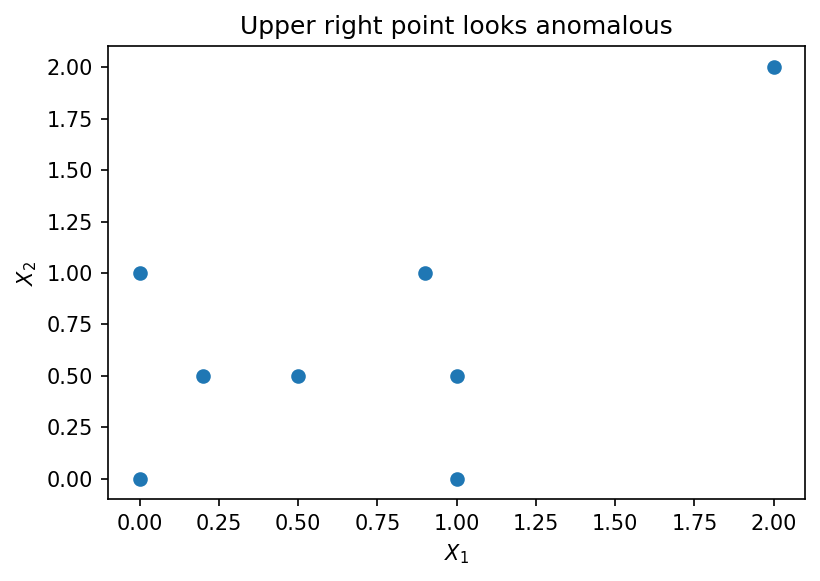

In [ ]:
X = np.array([[0.9, 1], [0, 1], [1, 0], [0, 0], [0.5, 0.5], [0.2, 0.5], [1, 0.5], [2, 2]])

plt.figure(dpi=150)
plt.title('Upper right point looks anomalous')
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.plot(X[:, 0], X[:, 1], 'o');

Let's create a function to visualize a query point and its neighbors more explicitly.

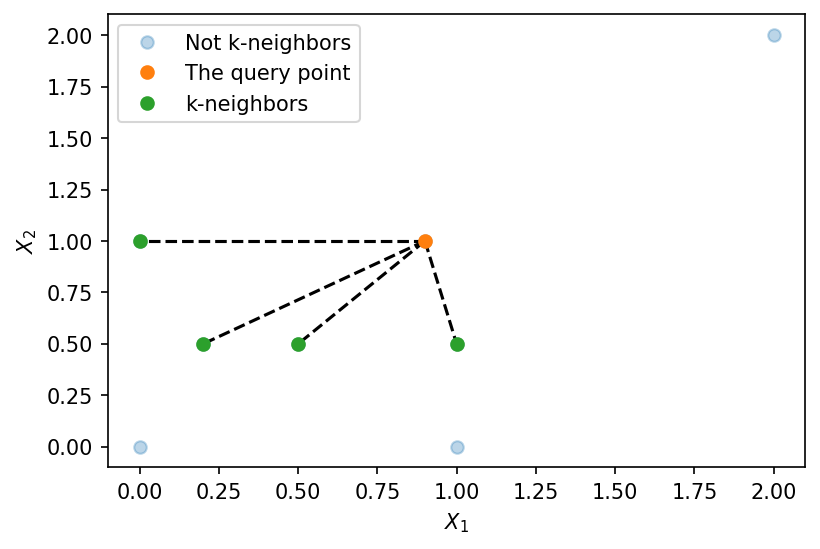

In [ ]:
def plot_point_and_k_neighbors(X, highlight_index, n_neighbors=2):
    "Plots the points in X, and shows the n_neighbors of the highlight_index-th point"
    nn = neighbors.NearestNeighbors(n_neighbors=n_neighbors).fit(X)
    dist, index = nn.kneighbors()
    
    src_pt = X[highlight_index, :]
    
    plt.figure(dpi=150)
    # draw lines first, so points go on top
    for dest_index in index[highlight_index]:
        dest_pt = X[dest_index, :]
        plt.plot(*list(zip(src_pt, dest_pt)), 'k--')
    plt.plot(X[:, 0], X[:, 1], 'o', label='Not k-neighbors', alpha=0.3)
    plt.plot(*src_pt, 'o', label='The query point')
    plt.plot(X[index[highlight_index], 0], X[index[highlight_index], 1], 'o', label='k-neighbors')
    plt.xlabel('$X_1$')
    plt.ylabel('$X_2$')
    plt.legend()
    
# Example of usage
plot_point_and_k_neighbors(X, 0, 4)

Here we can see the 4 points close to the query point (index of 0 in our data) are relatively close. Let's look at the anomalous point in the upper right (this point has an index of 7):

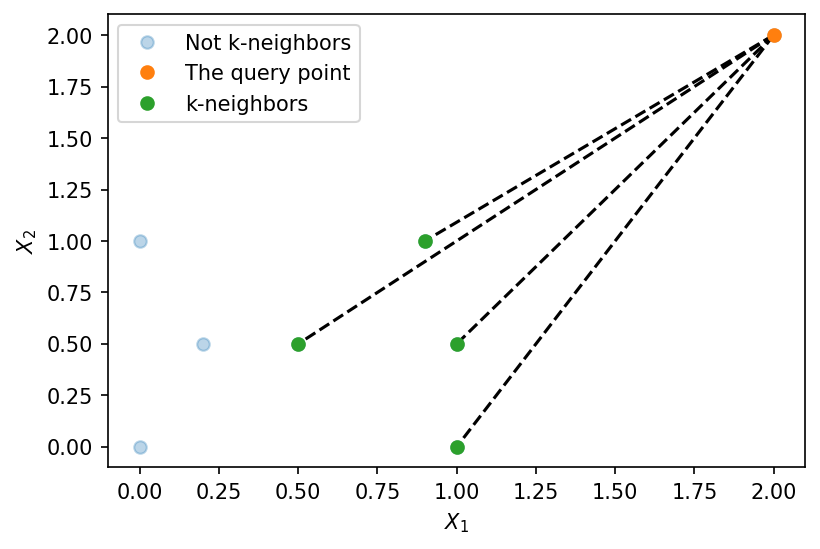

In [ ]:
plot_point_and_k_neighbors(X, 7, n_neighbors=4)

We can see in this case all of the 4-nearest neighbors to our point are far away, so it seems reasonably unambiguous to call this point an anomaly.

Let's add one more point next to the anomaly, and see how choosing "k" and the scoring function affects things.

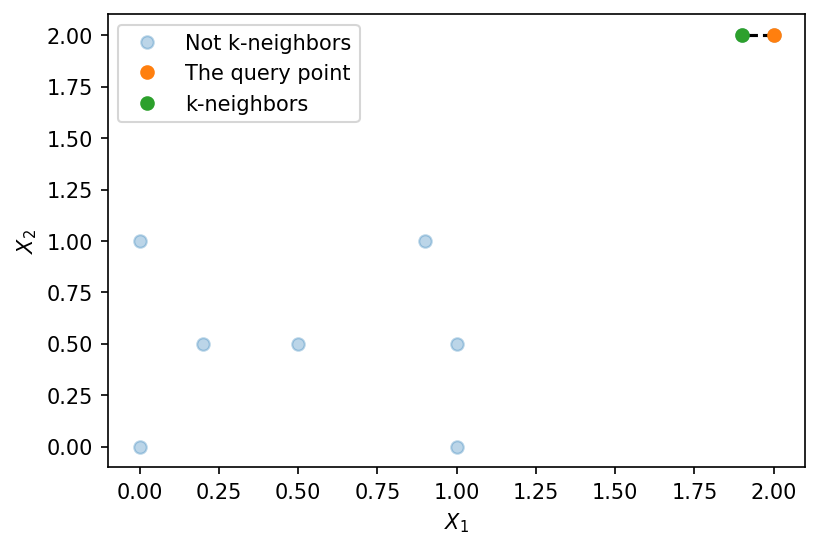

In [ ]:
# Toy dataset with two adjacent anomalies
X2 = np.concatenate([X, [[1.9, 2.0]]])

# Look at nearest neighbor (k=1)
plot_point_and_k_neighbors(X2, 7, n_neighbors=1)

### Observation 1: dependence on $k$

The distance between point 7 and the new point is actually quite small—smaller than the distances between any pair of the points in the lower left. If $k=1$, the two points in the upper right would be the _last_ ones to classified as an anomaly (i.e. they would have the lowest score).

### Observation 2: how to weight distances?

Let's look at the same data set (i.e. with the additional point) but now look at $k=3$

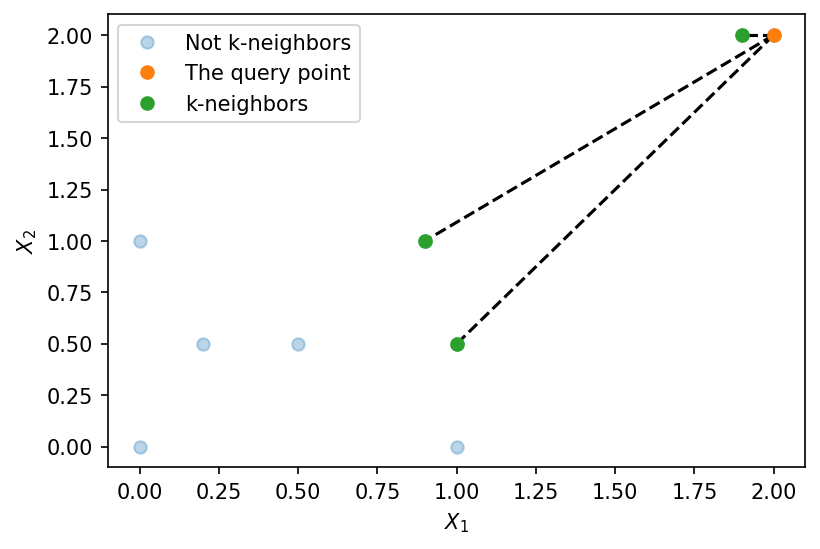

In [ ]:
plot_point_and_k_neighbors(X2, 7, n_neighbors=3)

We see one of the 3 nearest neighbors is very close, but the other two are far away. We need some way of combining these 3 distances into a single score. The three commonly used methods are
1. Use the longest distance
2. Use the (arithmetic) mean distance
3. Use the harmonic mean.

We will implement the longest distance, and assign the arithmetic mean distance and harmonic mean distance as exercises.

### Using the longest distance

In [ ]:
def do_nn_outlier_scores(obs, n_neighbors=1):
    """
    Gives the score of a point as the distance from point to its k-th nearest neighbor.
    Larger score means more likely to be an outlier
    """
    nn = neighbors.NearestNeighbors(n_neighbors=n_neighbors)
    nn.fit(obs)
    dists, idx = nn.kneighbors()
    scores = dists[:,-1]
    return scores

# Test 
do_nn_outlier_scores(X2, n_neighbors=3)

array([0.8602, 0.9   , 0.9434, 1.    , 0.6403, 0.5385, 0.5099, 1.8028,
       1.7493])

We can make the output a little easier to understand

In [ ]:
def print_ranked_scores(obs, scores):
    scores_and_obs = sorted(zip(scores, obs), key=lambda t: t[0], reverse=True)
    print('Rank  Point\t\tScore')
    print('------------------------------')
    for index, score_ob in enumerate(scores_and_obs):
        score, point = score_ob
        print(f'{index+1:3d}.  {point}\t\t{score:6.4f}')

# Look at the outliers using 3 neighbors
print_ranked_scores(X2, do_nn_outlier_scores(X2, 3))

Rank  Point		Score
------------------------------
  1.  [2. 2.]		1.8028
  2.  [1.9 2. ]		1.7493
  3.  [0. 0.]		1.0000
  4.  [1. 0.]		0.9434
  5.  [0. 1.]		0.9000
  6.  [0.9 1. ]		0.8602
  7.  [0.5 0.5]		0.6403
  8.  [0.2 0.5]		0.5385
  9.  [1.  0.5]		0.5099


Now look at the anomalies with k=1

In [ ]:
print_ranked_scores(X2, do_nn_outlier_scores(X2, 1))

Rank  Point		Score
------------------------------
  1.  [0. 1.]		0.5385
  2.  [0. 0.]		0.5385
  3.  [0.9 1. ]		0.5099
  4.  [1. 0.]		0.5000
  5.  [1.  0.5]		0.5000
  6.  [0.5 0.5]		0.3000
  7.  [0.2 0.5]		0.3000
  8.  [2. 2.]		0.1000
  9.  [1.9 2. ]		0.1000


**TAKEAWAY:** The number of neighbors $k$ used in kNN drastically changes the results. Usually requires some domain expertise to know the value of $k$ or range of values for $k$ to be used.

## kNN in reverse: outlier detection using in-degree (ODIN)

Here's an implementation of ODIN. Note that we convert the scores from the indegree value (low for an anomaly) to a zero-to-one scale where higher values are more of anomaly.

In [ ]:
def do_odin_outlier_scores(obs, n_neighbors=3):
    nn = neighbors.NearestNeighbors(n_neighbors=n_neighbors).fit(obs)
    graph = nn.kneighbors_graph()
    indegree = graph.sum(axis=0)  # sparse matrix

    # smaller indegree means more of an anomaly  
    # simple conversion to [0,1] so larger score is more of anomaly
    scores = (indegree.max() - indegree) / indegree.max()
    return np.array(scores)[0]  # convert to array

Score and rank the points for the _X2_ dataset (two adjacent anomalies).

In [ ]:
scores_odin = do_odin_outlier_scores(X2)

In [ ]:
print_ranked_scores(X2, scores_odin)

Rank  Point		Score
------------------------------
  1.  [0. 1.]		0.8333
  2.  [0. 0.]		0.8333
  3.  [2. 2.]		0.8333
  4.  [1.9 2. ]		0.8333
  5.  [1. 0.]		0.6667
  6.  [0.9 1. ]		0.1667
  7.  [0.2 0.5]		0.1667
  8.  [1.  0.5]		0.1667
  9.  [0.5 0.5]		0.0000


The two anomalies (2, 2) and (1.9, 2) have large scores, but so do the points (0, 1) and (0, 1). Also, the result is different from we found with k-means results. the method you use matters.

# Section 2: Cluster-Based Method (k-Means)

Clustering via k-means can be used as an anomaly detection method by:

  1. generating clusters, 
  2. finding the cluster of each example, 
  3. using the distance from the example to its cluster's center as a score
  
These pieces are available using `cluster.KMeans` which after fitting and predicting to get the clusters -- both where the clusters are and what cluster an example belongs to -- provides a `cluster_centers_` attribute.  Then we can use numpy's `numpy.linalg.norm` (often imported as `import numpy.linalg as nla`) to compute distances for us.

We will start by generating some data, then showing what the clusters are, and finally scoring the anomalies. 

**Data generation and view**

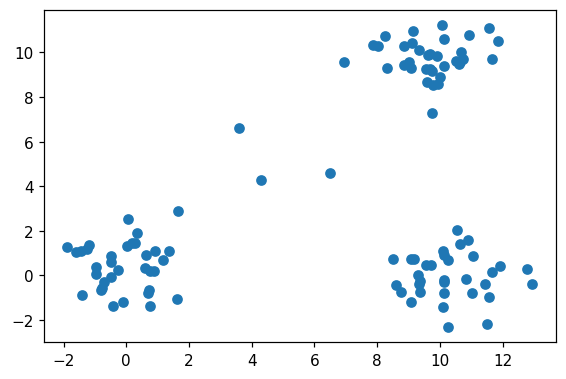

In [ ]:
blobs_X, cluster_labels = sk_data.make_blobs(centers=[[0,0], [10,10], [10,0]])
anomalies, _ = sk_data.make_blobs(centers=[[5,5]], n_samples=5, cluster_std=3, random_state=42)

data = np.concatenate([blobs_X, anomalies])
cluster_labels = np.concatenate([cluster_labels, [-1]*len(anomalies)])

# Display the data before clustering
plt.figure(dpi=110)
plt.plot(data[:, 0], data[:, 1], 'o');

**Clustering and show cluster assignment**

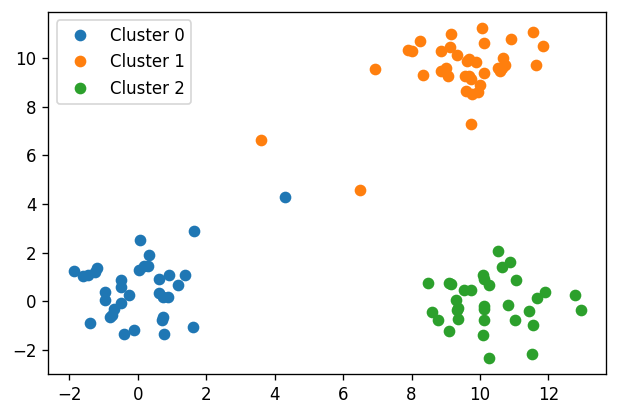

In [ ]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3).fit(data)

plt.figure(dpi=120)

for label in range(3):
    mask = (km.labels_ == label)
    plt.plot(data[mask, 0], data[mask, 1], 'o', label=f'Cluster {label}')
plt.legend();

You should run the clustering several times and note that the assignment of some points changes due to the different initial conditions (random choice of starting centroids).

**For each point, find the distance from the point to its centroid**

In [ ]:
centers = km.cluster_centers_[km.labels_]
# show the centers for the first 10 points
centers[:10]

array([[ 0.0493,  0.5616],
       [ 9.4485,  9.5246],
       [10.2952, -0.0238],
       [10.2952, -0.0238],
       [10.2952, -0.0238],
       [10.2952, -0.0238],
       [10.2952, -0.0238],
       [ 0.0493,  0.5616],
       [ 9.4485,  9.5246],
       [10.2952, -0.0238]])

In [ ]:
#Get the distances to the centers as use these as the scores
score = np.linalg.norm(data - centers, axis=1)
score

array([1.4885, 1.2723, 1.7386, 1.4294, 0.8944, 1.1903, 1.9567, 1.4178,
       0.5944, 1.587 , 0.967 , 2.6236, 1.4592, 1.6809, 0.4303, 2.6716,
       0.9119, 0.4774, 1.6656, 0.5336, 1.1814, 1.4712, 0.8278, 0.7606,
       1.1437, 0.5849, 2.0521, 0.6959, 1.6937, 1.3835, 2.2553, 2.054 ,
       1.7272, 2.0459, 2.0931, 0.9746, 1.481 , 2.4621, 1.122 , 1.3675,
       0.7608, 1.3881, 1.0505, 1.0566, 0.6265, 1.068 , 0.5411, 1.145 ,
       1.7502, 1.0015, 0.7123, 1.9289, 1.3137, 2.207 , 2.295 , 0.842 ,
       0.4758, 1.6323, 0.5925, 1.0183, 2.5774, 0.2399, 1.1506, 1.2957,
       0.3244, 2.8318, 1.3839, 1.3826, 1.3595, 0.3626, 1.9695, 1.191 ,
       1.4685, 0.4452, 1.9635, 1.6973, 0.7482, 1.1358, 1.0437, 0.8869,
       0.5312, 0.9333, 0.9643, 1.1402, 0.6796, 1.1661, 0.9183, 1.0281,
       0.7863, 1.7608, 0.3838, 0.433 , 1.589 , 0.9861, 1.7554, 1.4756,
       0.9779, 1.8017, 2.4976, 0.2849, 5.6573, 2.5058, 6.5342, 5.7576,
       2.241 ])

What are the 5 points with the highest scores? We will call those the anomalies

In [ ]:

np.argsort(score)[::-1][:5]

array([102, 103, 100,  65,  15])

Show these results in a plot that includes the cluster centers (labeled with an 'x')

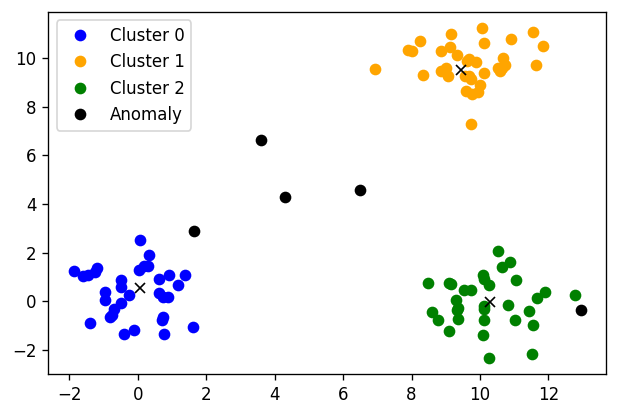

In [ ]:

from sklearn.cluster import KMeans

km = KMeans(n_clusters=3).fit(data)

anomaly_idx = np.argsort(score)[::-1][:5]
anomaly_mask = np.zeros(len(data))
anomaly_mask[anomaly_idx] = 1

plt.figure(dpi=120)
colors = ['blue', 'orange', 'green']

for label, color in enumerate(colors):
    mask = (km.labels_ == label) & (anomaly_mask == 0)
    plt.plot(data[mask, 0], data[mask, 1], marker='o', linestyle='none',
             color=color, label=f'Cluster {label}')
    plt.plot(*km.cluster_centers_[label], marker='x', color='k')

plt.plot(data[anomaly_idx, 0], data[anomaly_idx, 1], marker='o', linestyle='none',
         color='k', label='Anomaly')
plt.legend();

If you rerun the clustering enough times, you will find that the three central points are always labeled as anomalies. The other two anomalies vary depending on how the points are clustered.

**Note**: even bigger changes can be expected if the number of clusters is varied. Below we illustrate the effect of varying the number of clusters from 1 to 5.

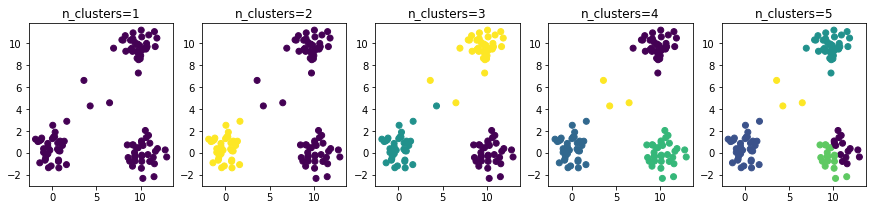

In [ ]:
# Show clustering for user-specified number of clusters
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,5, figsize=(15,3))
for ax, n_clusters in zip(axes, [1,2,3,4,5]):
    clust = KMeans(n_clusters=n_clusters)
    obs_to_clusters = clust.fit_predict(data) 
    ax.scatter(*data.T, c=obs_to_clusters)
    ax.set_title("n_clusters={}".format(n_clusters))